In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
import pickle

import os
#Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score



 # The objective of this project is to build a model that can create relevant summaries for reviews written about fine foods sold on Amazon. This dataset contains above 5,00,000 reviews.

In [62]:
df = pd.read_csv("Reviews.csv")
data =  df.copy()
print(data.shape)
data.head()

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [63]:
data.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [64]:
data.Score[data.Score<=3]=0
data.Score[data.Score>=4]=1

In [65]:
final = data[data.HelpfulnessNumerator <= data.HelpfulnessDenominator]
print(final.shape)
final


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,1,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,0,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,1,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,1,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


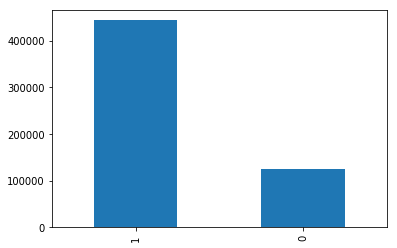

In [201]:
ax=final.Score.value_counts().plot(kind='bar')
fig = ax.get_figure()

In [66]:
#nltk.download('stopwords')
stop = stopwords.words('english') #All the stopwords in English language
#excluding some useful words from stop words list 
excluding = ['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stop = [words for words in stop if words not in excluding]
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's',

In [67]:
def striphtml(data):
    p = re.compile('<.*?>')#Find this kind of pattern

    return p.sub('',data) #Substitute nothing at the place of strings which matched the patterns

def strippunc(data):
    p = re.compile(r'[?|!|\'|"|#|.|,|)|(|\|/|~|%|*]')
    return p.sub('',data)
strippunc("fsd*?~,,,( sdfsdfdsvv)#")

from nltk.stem import SnowballStemmer
snow = SnowballStemmer('english') #initialising the snowball stemmer

# Hence in the Preprocessing phase we do the following in the order below:-

 ### 1. Begin by removing the html tags
### 2. Remove any punctuations or limited set of special characters like , or . or # etc.
### 3. Check if the word is made up of english letters and is not alpha-numeric
### 4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
### 5. Convert the word to lowercase
### 6. Remove Stopwords
### 7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)
### 8. After which we collect the words used to describe positive and negative reviews

In [171]:
## Just trying on 1 review to observe how it works

str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'][2:3].values: #Running only for 2nd review
    filtered_sentence=[]
    print(sent) #Each review
    sent=striphtml(sent)# remove HTMl tags
    sent=strippunc(sent)# remove Punctuation Symbols
    print(sent.split())
    for w in sent.split():
        print("================================>",w)
        if((w.isalpha()) and (len(w)>2)):#If it is a numerical value or character of lenght less than 2    
            if(w.lower() not in stop):# If it is a stopword
                s=(snow.stem(w.lower())).encode('utf8') #Stemming the word using SnowBall Stemmer
                print("Selected: Stem Word->",s)
                filtered_sentence.append(s)
            else:
                print("Eliminated as it is a stopword")
                continue
        else:
            print("Eliminated as it is a numerical value or character of lenght less than 2")
            continue 
#     print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    #print("***********************************************************************")
    #print("Finally selected words from the review:\n",final_string)


This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, and The Wardrobe" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch.
['This', 'is', 'a', 'confection', 'that', 'has', 'been', 'around', 'a', 'few', 'centuries', 'It', 'is', 'a', 'light', 'pillowy', 'citrus', 'gelatin', 'with', 'nuts', '-', 'in', 'this', 'case', 'Filberts', 'And', 'it', 'is', 'cut', 'into', 'tiny', 'squares', 'and', 'then', 'liberally', 'coated', 'with', 'powdered', 'sugar', 'And', 'it', 'is', 'a', 'tiny', 'mouthful', 'of', 'heaven', 'Not', 'too', 'chewy', 'and', 'very', 'flavorful', 'I', 'highly', 'recommend', 'this', 'yummy', 'treat', 

In [68]:
%%time
# With stemming operation
i=0
str1=' '
final_string=[]
all_positive_words=[]                # store words from +ve reviews here
all_negative_words=[]               # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=striphtml(sent)                   # remove HTMl tags
    sent=strippunc(sent)                    # remove Punctuation Symbols
    for w in sent.split():
        if((w.isalpha()) and (len(w)>2)):      #If it is a numerical value or character of lenght less than 2    
            if(w.lower() not in stop):             # If it is a stopword
                s=(snow.stem(w.lower())).encode('utf8') #Stemming the word using SnowBall Stemmer
                filtered_sentence.append(s)
                if (final['Score'].values)[i] == 'Positive': 
                    all_positive_words.append(s) #list of all words used to describe positive reviews
                if(final['Score'].values)[i] == 'Negative':
                    all_negative_words.append(s) #list of all words used to describe negative reviews reviews
            else:
                continue
        else:
            continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    final_string.append(str1)
    #print("***********************************************************************")
    #print("Finally selected words from the review:\n",final_string)
    i+=1
print(len(final_string))
final['CleanedText']=final_string

568452
Wall time: 15min 13s


In [69]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...


In [70]:
from sklearn.model_selection import train_test_split
##Sorting data according to Time in ascending order for Time Based Splitting
time_sorted_data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

x = time_sorted_data['CleanedText'].values
y = time_sorted_data['Score']

# split the data set into train and test
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(397916,) (170536,) (397916,) (170536,)


### We cannot work with text directly when using machine learning algorithms.Instead, we need to convert the text to numbers.Algorithms take vectors of numbers as input, therefore we need to convert documents to fixed-length vectors of numbers.A simple and effective model for thinking about text documents in machine learning is called the Bag-of-Words Model, or BoW.
### The CountVectorizer provides a simple way to both tokenize a collection of text documents and build a vocabulary of known words, but also to encode new documents using that vocabulary. 

In [71]:
#Bag of Words (BoW)
count_vect = CountVectorizer(min_df = 10) 
X_train_vec = count_vect.fit_transform(X_train)
X_test_vec = count_vect.transform(X_test)
print("the type of count vectorizer :",type(X_train_vec))
print("the shape of out text BOW vectorizer : ",X_train_vec.get_shape())
print("the number of unique words :", X_train_vec.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (397916, 19100)
the number of unique words : 19100


In [72]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X_train_vec_standardized = sc.fit_transform(X_train_vec)
X_test_vec_standardized = sc.transform(X_test_vec)

### Grid Search CV
Grid search is an approach to parameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid.
### Randomized Search CV
Random search is an approach to parameter tuning that will sample algorithm parameters from a random distribution (i.e. uniform) for a fixed number of iterations. A model is constructed and evaluated for each combination of parameters chosen.

## SGD Classifier
SGD Classifier implements regularised linear models with Stochastic Gradient Descent.So, what is SGD is doing is actually scanning through the all the training data points and for the first training data point it looks at the cost function, calculates the gradient to modify the model parameters so that only the first predicted value for training data point fits to the actual value better. Then it will go to the second training data point and again modify the previously calculated model parameters to only fit the second training data point better (ignoring the previous training data point). It will again do the same to the third training data point to modify the previously calculated training parameters so that only the third predicted training data point fits better to the actual value. This process continues until it covers all the m data points in the training data set. This concludes one iteration or epoch of the SGD. This entire process will again repeat till a solution is found.

In [73]:
#GridSearchCV Implementation
# Importing libraries
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score
from sklearn.model_selection import cross_val_score

Alpha = [0.0001,0.001, 0.01, 0.1, 1, 10]

param_grid = {'alpha': Alpha}
model = GridSearchCV(SGDClassifier(), param_grid, scoring = 'f1_micro', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)

Model with best parameters :
 SGDClassifier(alpha=0.1, average=False, class_weight=None, early_stopping=False,
              epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
              learning_rate='optimal', loss='hinge', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Accuracy of the model :  0.8928496036027583
The optimal value of alpha(1/C) is :  0.1


In [74]:
warnings.filterwarnings('ignore')
#confusion matrix,precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
print("Test Parameters")
Y_pred = sgd.predict(X_test_vec_standardized)
Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_test_accuracy))
f1score= f1_score(Y_test, Y_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,average='weighted')
print('precision score  for   the model is: %s'% precisionscore)
y_train_pred = sgd.predict(X_train_vec_standardized)
print()
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
print("Train Parameters")
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,pos_label='positive',average='weighted')
print('precision score  for   the model is: %s'% precisionscore)

Test Parameters
Accuracy of the model at optimal hyperparameter alpha = 0.100000% is:  89.272060%
f1 score value for   the model is: 0.8880480518468967
precision score  for   the model is: 0.8888499216112815

Train Parameters
Accuracy of the model at optimal hyperparameter alpha = 0.100000% is:  90.637723%
f1 score value for   the model is: 0.9023953126245627
precision score  for   the model is: 0.9038421032616855


In [75]:
#Using Randomized Search CV to find best parameters
# Load libraries

from scipy.stats import uniform

# Create regularization hyperparameter distribution using uniform distribution
Alpha = uniform(loc=0, scale=1)

# Create hyperparameter options
hyperparameters = dict(alpha=Alpha)

#Using RandomizedSearchCV
model = RandomizedSearchCV(SGDClassifier(), hyperparameters, scoring = 'f1_micro', cv=3 , n_jobs = -1,pre_dispatch=2)
model.fit(X_train_vec_standardized, Y_train)
print("Model with best parameters :\n",model.best_estimator_)
print("Accuracy of the model : ",model.score(X_test_vec_standardized, Y_test))

optimal_alpha = model.best_estimator_.alpha
print("The optimal value of alpha(1/C) is : ",optimal_alpha)
print()

#precision matrix,recall matrix,accuracy
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
sgd = SGDClassifier(alpha=optimal_alpha, n_jobs=-1)
sgd.fit(X_train_vec_standardized,Y_train)
Y_pred = sgd.predict(X_test_vec_standardized)
print("Test Scores")

Y_test_accuracy = accuracy_score(Y_test, Y_pred, normalize=True, sample_weight=None)*100
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_test_accuracy))
f1score= f1_score(Y_test, Y_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_test, Y_pred,average='weighted')
print('precision score  for   the model is: %s'% precisionscore)
print()
print("Train Scores")
y_train_pred = sgd.predict(X_train_vec_standardized)
Y_train_accuracy =accuracy_score(Y_train, y_train_pred, normalize=True, sample_weight=None)*100
#plot_confusion_matrix(Y_train, y_train_pred)
print('Accuracy of the model at optimal hyperparameter alpha = %f%% is:  %f%%' % (optimal_alpha,Y_train_accuracy))
f1score= f1_score(Y_train, y_train_pred, average='weighted')
print('f1 score value for   the model is: %s'% f1score)
precisionscore=precision_score(Y_train, y_train_pred,average='weighted')
print('precision score  for   the model is: %s'% precisionscore)

Model with best parameters :
 SGDClassifier(alpha=0.14604441595295203, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Accuracy of the model :  0.8912135854013228
The optimal value of alpha(1/C) is :  0.14604441595295203

Test Scores
Accuracy of the model at optimal hyperparameter alpha = 0.146044% is:  89.116081%
f1 score value for   the model is: 0.8856828748578753
precision score  for   the model is: 0.8873289413335012

Train Scores
Accuracy of the model at optimal hyperparameter alpha = 0.146044% is:  90.348717%
f1 score value for   the model is: 0.8987753411711767
precision score  for   the model is: 0.9010244588093905


### Result

In [205]:
test_op = (sgd.predict(X_test_vec))
tup=list(zip(X_test,Y_test,test_op))
print('********************Model Performance on Test Data************************')
pd.DataFrame(tup, columns=['Test Reviews','Original Score','Model Prediction']).head(10)

********************Model Performance on Test Data************************


,Test Reviews,Original Score,Model Prediction
0,b'lucki receiv gift packag lake champlain hot ...,1,1
1,b'admit dont know much babi dont one receiv ba...,1,1
2,b'like amazon method regular ship favorit coff...,1,1
3,b'ever fresh open gourmet coffe wonder happen ...,0,1
4,b'saw bar wyom somewher buddi love hotnspici p...,1,1
5,b'make waffl mix flour tast great healthi grap...,1,1
6,b'amaz much got small price best coffe ive tas...,1,1
7,b'use coconut oil past day happi result first ...,1,1
8,b'ill start note love almond eat almond everi ...,1,1
9,b'dog favorit flavor blue buffalo biscuit reas...,1,1
